In [1]:
import torch
from torch.autograd import Variable
import torch.functional as F
import dataLoader
from torch.utils.data import DataLoader
import faceNet
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
# set device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"device is {device}")

device is cuda


In [3]:
# Initialize dataLoader
faceDataset = dataLoader.BatchLoader(
        imageRoot = '/datasets/cs252-sp21-A00-public/hw2_data/CASIA-WebFace',
        alignmentRoot = './data/casia_landmark.txt',
        cropSize = (96, 112)
        )
faceLoader = DataLoader(faceDataset, batch_size = 1, num_workers = 16, shuffle = False )

In [57]:
# load network
net_type = 'faceNet'
model_path = '/datasets/home/80/080/chw357/cse252d/cse252d-sp21-hw2/cosFace/checkpoint/netFinal_8.pth'
net = getattr(faceNet, net_type)()
net.load_state_dict(torch.load(model_path))
net.to(device)
net.eval()
net.feature = True

In [58]:
# sample_idxes = np.random.choice(np.arange(len(faceLoader)), size=10, replace=False)
sample_idxes = np.array([237082, 358063, 153592, 328405,  87246,  45483, 126051, 395463,
       435563, 109603])
net_outputs = []
plot_imgs = []

for face_idx in sample_idxes:
    img = faceLoader.dataset[face_idx]["img"]
    img_plot = faceLoader.dataset[face_idx]["img_aligh"]
    img_plot = img_plot.transpose(1,2,0)
    
    # convert to tensor
    img_net = img.reshape((1,3,112,96))
    img_net = Variable(torch.from_numpy(img_net).float()).to(device)
    
    # sent to netowrk
    net_outputs.append(net(img_net).cpu().detach().numpy())
    plot_imgs.append(img_plot)

In [59]:
net_outputs_np = np.vstack(net_outputs)
net_outputs_np.shape

(10, 512)

In [63]:
# use tsne to vis data
X_embedded = TSNE(n_components=2).fit_transform(net_outputs_np)
X_embedded.shape

(10, 2)

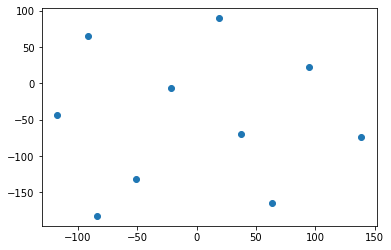

In [64]:
plt.scatter(X_embedded[:,0],X_embedded[:,1])

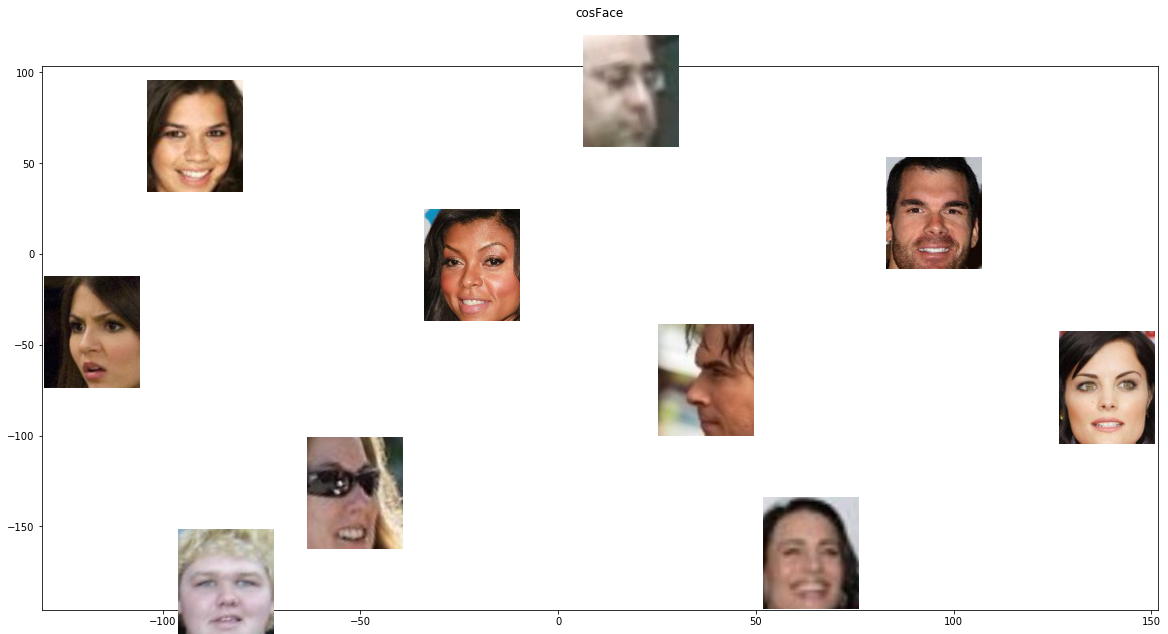

In [68]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def getImage(img):
    return OffsetImage(img[:, :, ::-1]) # convert imge back to rgb, img original is bgr


x = X_embedded[:,0]
y = X_embedded[:,1]

fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(x, y) 

for x0, y0, path in zip(x, y, plot_imgs):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)
plt.title("cosFace",y=1.08)
# plt.savefig("cosFace_tsne_bn.jpg", bbox_inches="tight")